In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
from keras.datasets import cifar10

In [5]:
import keras
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

170500096/170498071 [==============================] - 4s 0us/step


In [6]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
num_classes = 10
# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
X_train.shape

(50000, 32, 32, 3)

In [0]:
from keras import models, layers
from keras.models import Model
from keras.layers import BatchNormalization, Activation, Flatten
from keras.optimizers import Adam
from keras import regularizers

In [0]:
batch_size = 64
num_classes = 10
epochs = 200
l = 6
num_filter = 35
compression = 1

In [0]:
# Dense Block
def denseblock(input, num_filter = 12):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
      
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    c=layers.Conv2D(10, (1, 1), padding='valid')(AvgPooling)

    avg=layers.GlobalAveragePooling2D()(c)
    output=layers.Activation('softmax')(avg)
    
    return output

In [12]:
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter)
First_Transition = transition(First_Block, num_filter)

Second_Block = denseblock(First_Transition, num_filter)
Second_Transition = transition(Second_Block, num_filter)

Third_Block = denseblock(Second_Transition, num_filter)
Third_Transition = transition(Third_Block, num_filter)

Last_Block = denseblock(Third_Transition,  num_filter)
output = output_layer(Last_Block)

In [13]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 35)   945         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 35)   140         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 35)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [14]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [0]:
from keras.callbacks import ModelCheckpoint

filepath="weights-improve-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Image Agumentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        
        rotation_range=30,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        zoom_range=0.10
        )  #

In [17]:
datagen.fit(X_train)

    # fit the model on the batches generated by datagen.flow()
history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_test, y_test),
                        epochs=200, verbose=1, workers=4,
                        callbacks=callbacks_list
                        )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
781/781 [==============================] - 85s 109ms/step - loss: 1.4650 - acc: 0.4668 - val_loss: 1.7770 - val_acc: 0.4682

Epoch 00001: val_acc improved from -inf to 0.46820, saving model to weights-improve-01-0.47.hdf5
Epoch 2/200
781/781 [==============================] - 73s 93ms/step - loss: 1.0677 - acc: 0.6201 - val_loss: 1.2918 - val_acc: 0.5802

Epoch 00002: val_acc improved from 0.46820 to 0.58020, saving model to weights-improve-02-0.58.hdf5
Epoch 3/200
781/781 [==============================] - 73s 93ms/step - loss: 0.8965 - acc: 0.6861 - val_loss: 1.6210 - val_acc: 0.5194

Epoch 00003: val_acc did not improve from 0.58020
Epoch 4/200
781/781 [==============================] - 72s 93ms/step - loss: 0.7890 - acc: 0.7240 - val_loss: 1.0675 - val_acc: 0.6643

Epoch 00004: val_acc improved from 0.58020 to 0.66430, saving model to weights-improve-04-0.66.hdf5
Epoch 5/200


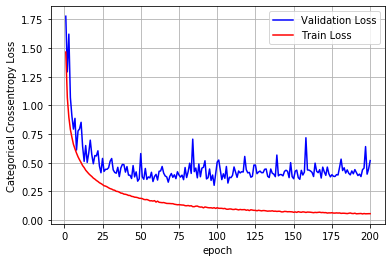

In [18]:
import matplotlib.pyplot as plt
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [19]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 3s 349us/step
Test loss: 0.5177401971131563
Test accuracy: 0.8935


In [0]:
import pandas as pd
import numpy as np

In [0]:
model.load_weights("weights-improve-174-0.91.hdf5")

In [0]:
labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
    
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([labels[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([labels[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [23]:
pd.set_option('display.max_columns', 10)
print(confusion_matrix(y_test, model.predict(X_test)))

Pred        airplane  automobile  bird  cat  deer  dog  frog  horse  ship  \
True                                                                        
airplane         897           6    19    4     5    2     7      1    43   
automobile         1         970     1    0     0    0     0      1     5   
bird              10           0   918   14    24    5    17      8     3   
cat                8           8    36  791    34   62    39      8     5   
deer               3           0    21   12   940    5     9      8     0   
dog                6           1    22   84    25  824    16     18     2   
frog               4           0    18    8     3    0   965      0     0   
horse              3           1    12    7    25   12     4    933     1   
ship              12           6     2    1     0    0     1      1   969   
truck              4          34     1    3     1    0     3      1    11   

Pred        truck  
True               
airplane       16  
automobile     

In [25]:
score = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 3s 332us/step


In [26]:

score

[0.37590156150981785, 0.9149]

## Observation:

1.After training 200 epochs we achieved test accuracy of 91.49%.